In [9]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [10]:
df = pd.read_csv(os.path.join("data","train.csv"))

#### Preprocessing

In [8]:
from tensorflow.keras.layers import TextVectorization

In [43]:
X = df["comment_text"]
y = df[df.columns[2:]].values

In [10]:
MAX_FEATURES = 200000 #number of words in the vocab

In [11]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                                output_sequence_length=1800,
                                output_mode="int")

In [46]:
vectorizer.adapt(X.values)

In [47]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [48]:
vectorized_text = vectorizer(X.values)

In [49]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [50]:
#MCSHBAP - map, cache, shuffle, batch, prefetch [DataPipeline]
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [20]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [21]:
train_generator = train.as_numpy_iterator()

#### Build deep learning model

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, Embedding

In [47]:
model = Sequential()
# Create embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation="tanh")))
# Feature extractor fully connected layers
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
# Final layer
model.add(Dense(6, activation="sigmoid"))

In [48]:
model.compile(loss = "BinaryCrossentropy", optimizer="adam")

In [49]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 ━━━━━━━━━━━━━━━━━━━━ 12950s 2s/step - loss: 0.0846 - val_loss: 0.0462


In [51]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

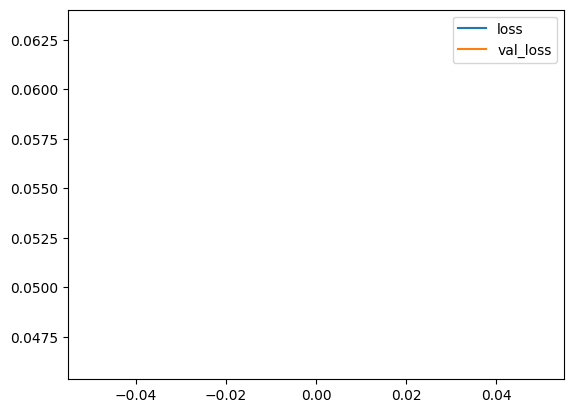

In [53]:
# This will give output when run for more than 1 epochs
plt.figure(figsize = (8,5))
pd.DataFrame(history.history).plot()
plt.show()

#### Make predictions

In [23]:
input_text = vectorizer("You freaking suck! I am going to hit you")

In [24]:
batch = test.as_numpy_iterator().next()

In [25]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [26]:
model.predict(np.expand_dims(input_text,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


array([[0.9891083 , 0.17554483, 0.87863517, 0.03735217, 0.75052977,
        0.11756625]], dtype=float32)

In [27]:
(model.predict(batch_X)>0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0]])

#### Evaluate model

In [17]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [18]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [19]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

NameError: name 'test' is not defined

In [ ]:
# Low cause less epochs
print(f"Precision : {pre.result().numpy()}, Recall : {re.result().numpy()}, Accuracy : {acc.result().numpy()} ")

#### Test and gradio

In [20]:
import gradio as gr

In [ ]:
model.save("toxicity.h5")

In [ ]:
model = tf.keras.models.load_model("toxicity.h5")

In [ ]:
input_str = vectorizer("Hey i frickin hate u")

In [ ]:
res = model.predict(np.expand_dims(input_str,0))

In [ ]:
res

In [21]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ""
    for idx, col in enumerate(df.columns[2:]):
        text += "{}: {}\n".format(col,results[0][idx]>0.5)

    return text

In [22]:
interface = gr.Interface(fn=score_comment,
                         inputs = gr.Textbox(lines = 2, placeholder = "Comment to score"),
                         outputs = "text")

In [23]:
interface.launch(share = False)

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\kumay\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\queueing.py", line 532, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kumay\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\route_utils.py", line 276, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kumay\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 1928, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kumay\AppData\Local\Programs\Python\Python312\Lib\site-packages\gradio\blocks.py", line 1514, in call_function
    prediction = await anyio.to_thread.run_sync(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kumay\AppData\Local\Programs\Python\Python312\Lib\sit

In [16]:
import tensorflow as tf
model = tf.keras.models.load_model('./toxicity.h5')
